In [12]:
import os

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from gala.mpl_style import laguna, hesperia

from twobody.transforms import PeKi_to_a

from hq.config import Config
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

In [2]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [5]:
c = Config.from_run_name('dr16-random')
alldata, allvisit = c.load_alldata()

In [4]:
gold = at.QTable.read('../../catalogs/gold_sample.fits')
bimodal = at.QTable.read('../../catalogs/bimodal.fits')
bimodal = at.QTable(bimodal[bimodal['LOGG'] > -0.5], masked=False)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [13]:
low_mass = gold[(gold['m2_min_50'] < 70*u.Mjup) & (gold['m2_min_50'] > 1*u.Mjup)]
print(len(low_mass))

high_mass = gold[(gold['m2_min_5'] > gold['mass']*u.Msun)]
print(len(high_mass))

qmin = gold['m2_min_50'].value / gold['mass']
Rstar = stellar_radius(gold['LOGG'], gold['mass']*u.Msun)
a1sini = PeKi_to_a(gold['MAP_P'], gold['MAP_e'], gold['MAP_K'])
asini = a1sini * (1 + 1/qmin)
rlimit = 0.49*qmin**(-2/3.) / (0.6*qmin**(-2/3.) + np.log(1 + qmin**(-1/3)))
roche = gold[(Rstar/asini).decompose() > rlimit]
print(len(roche))

81
21
16


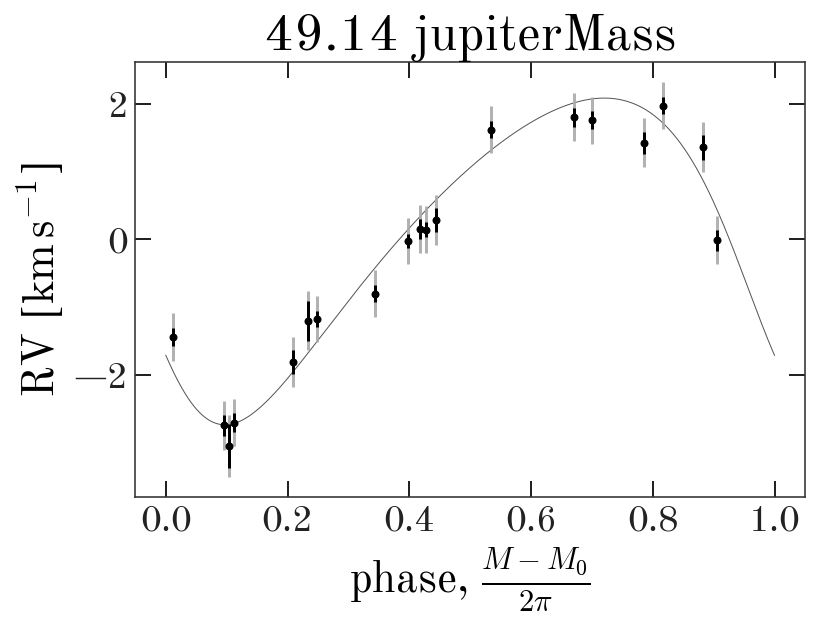

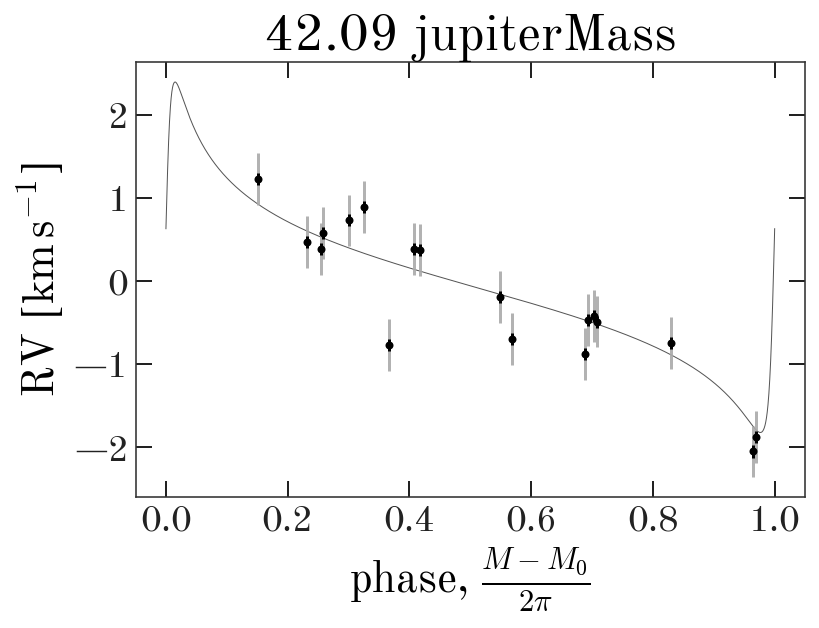

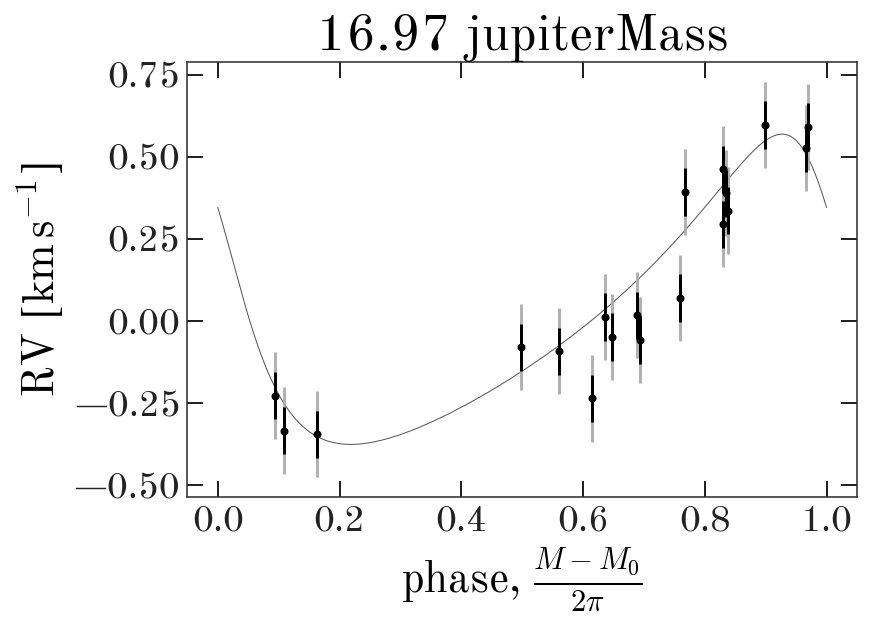

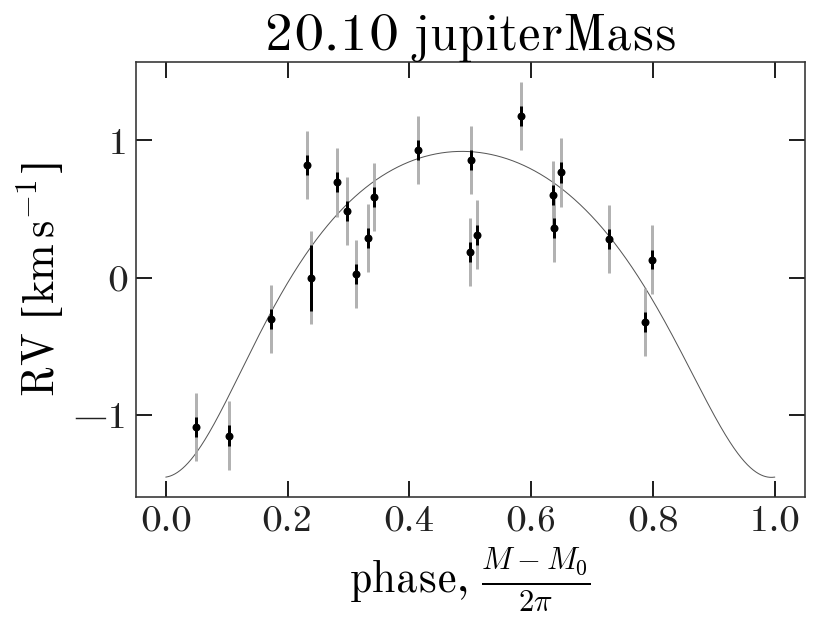

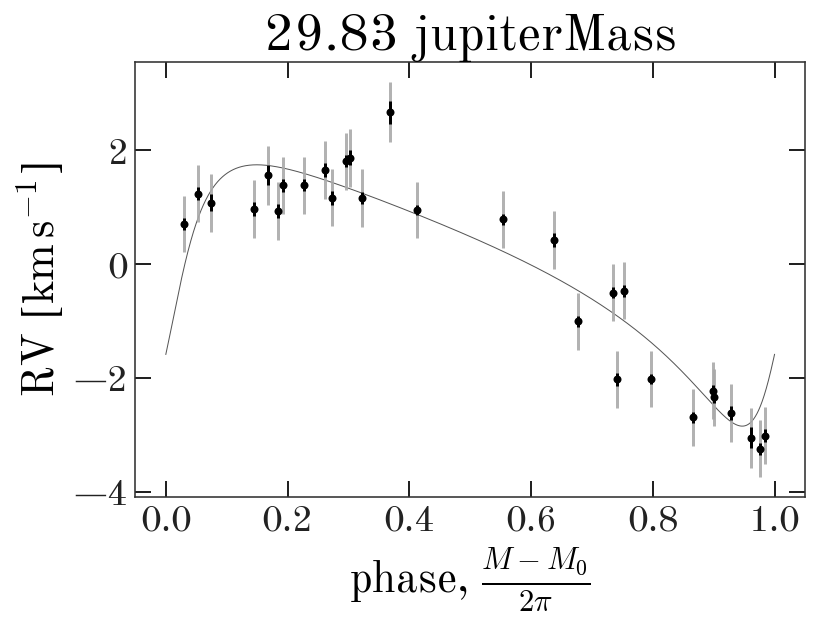

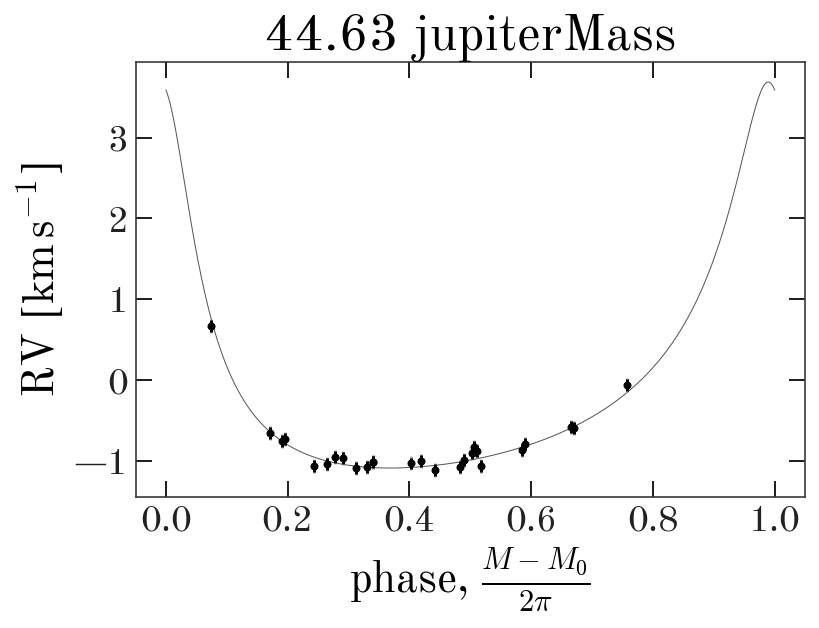

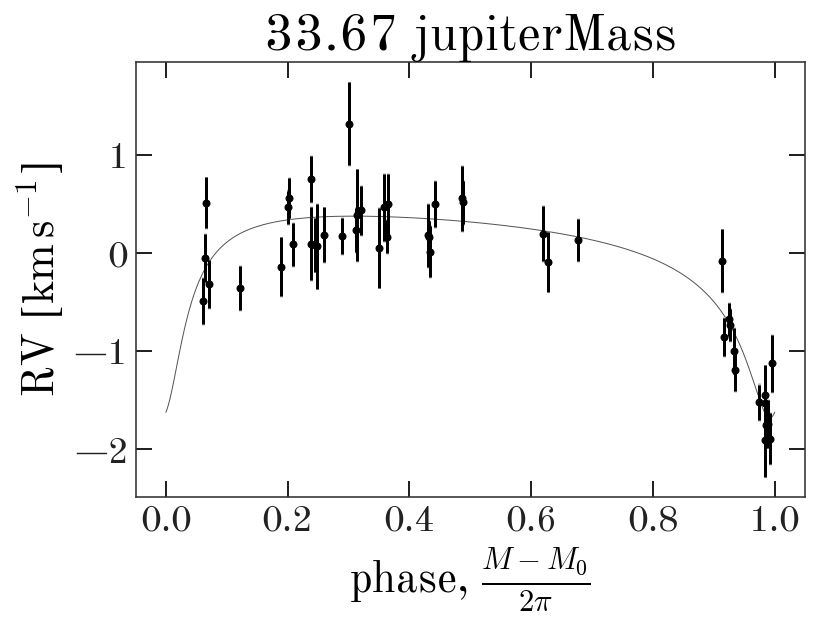

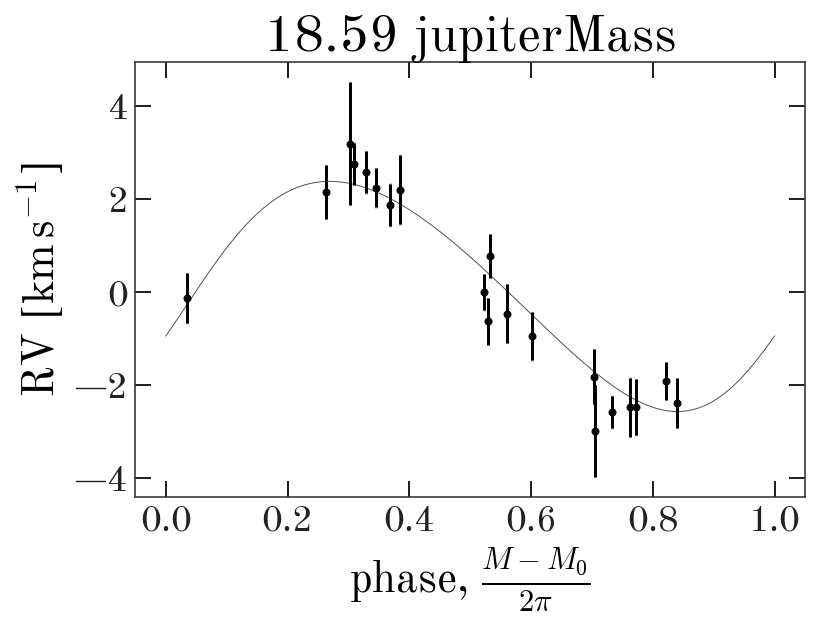

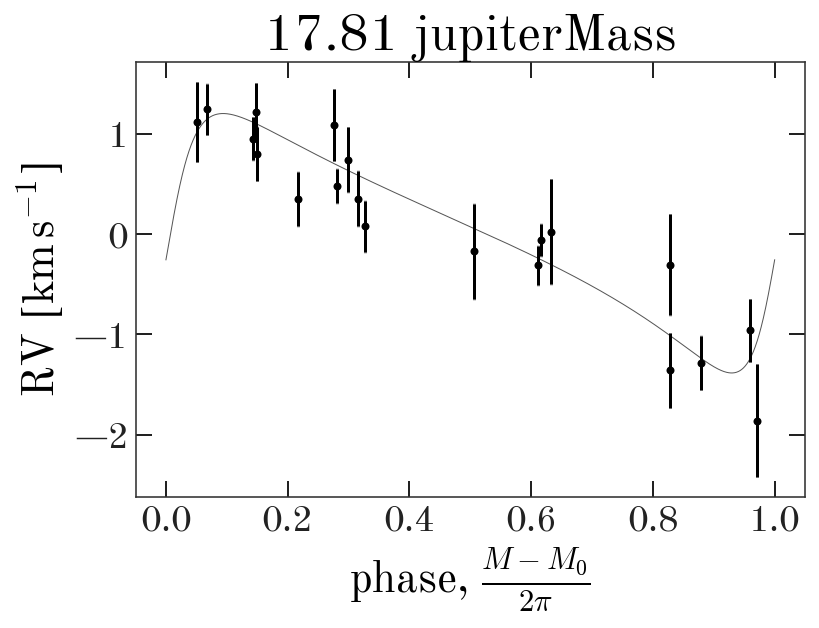

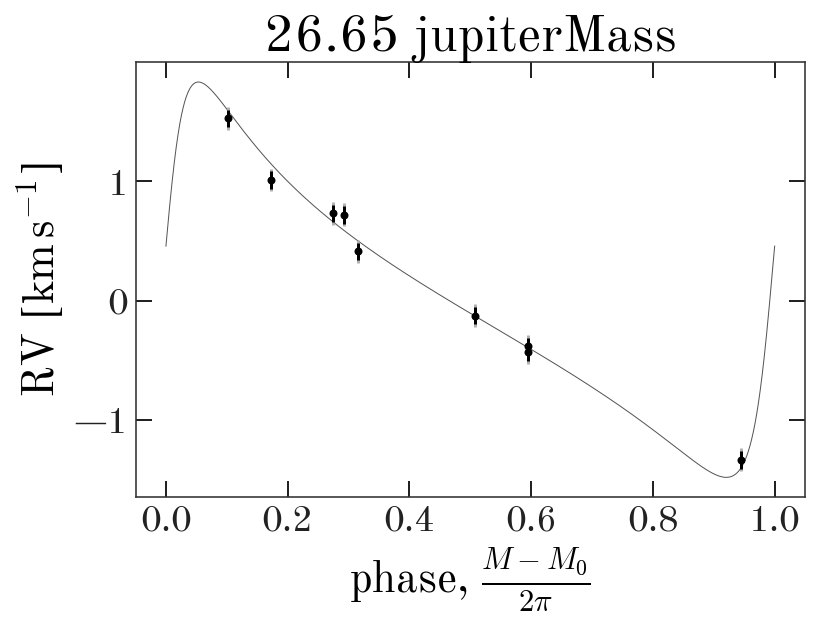

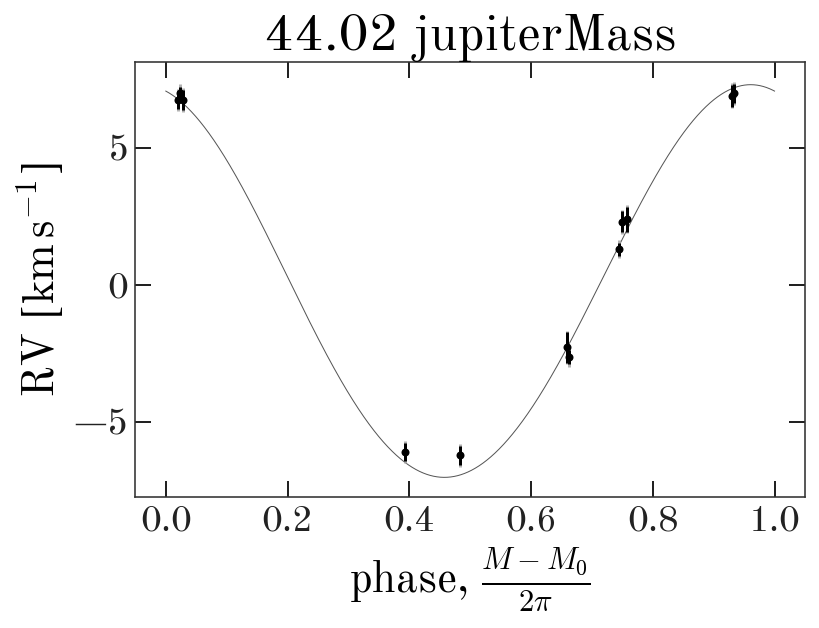

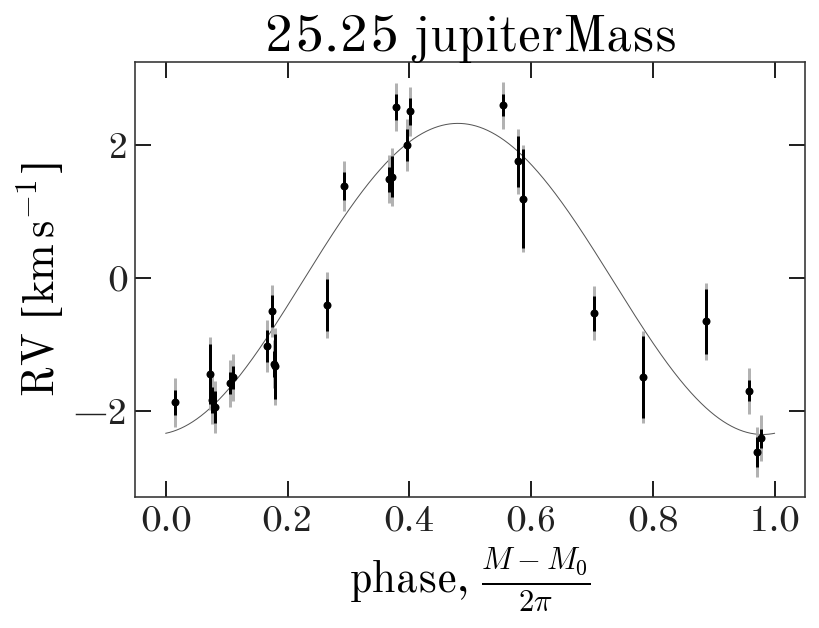

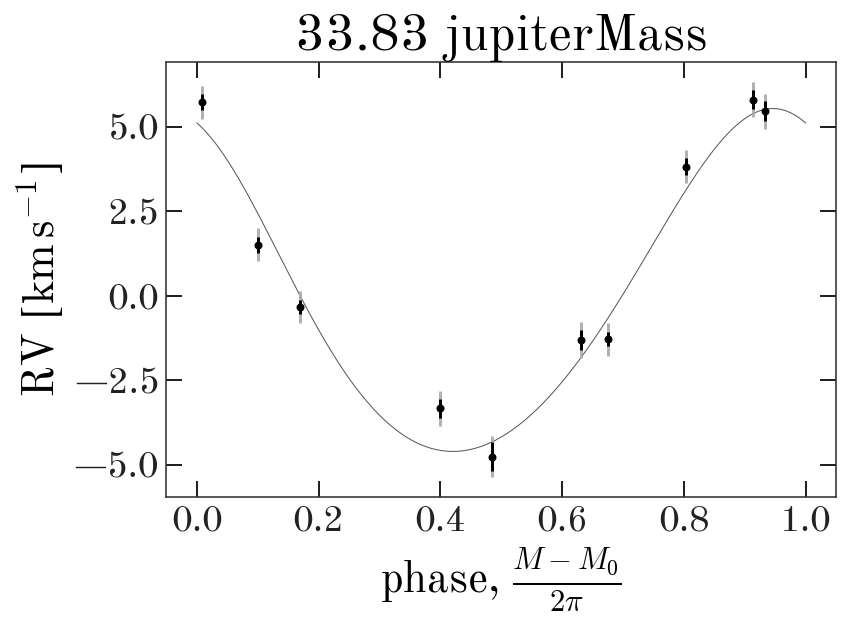

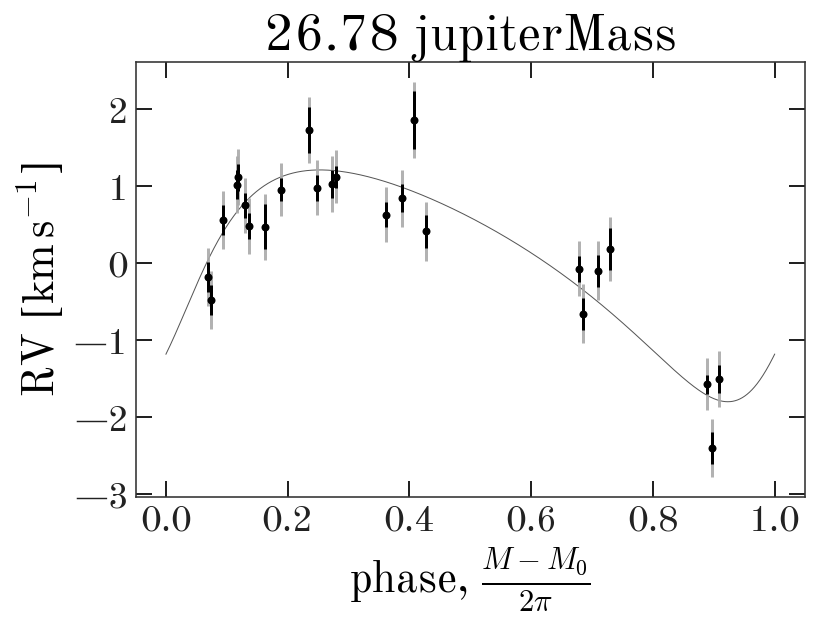

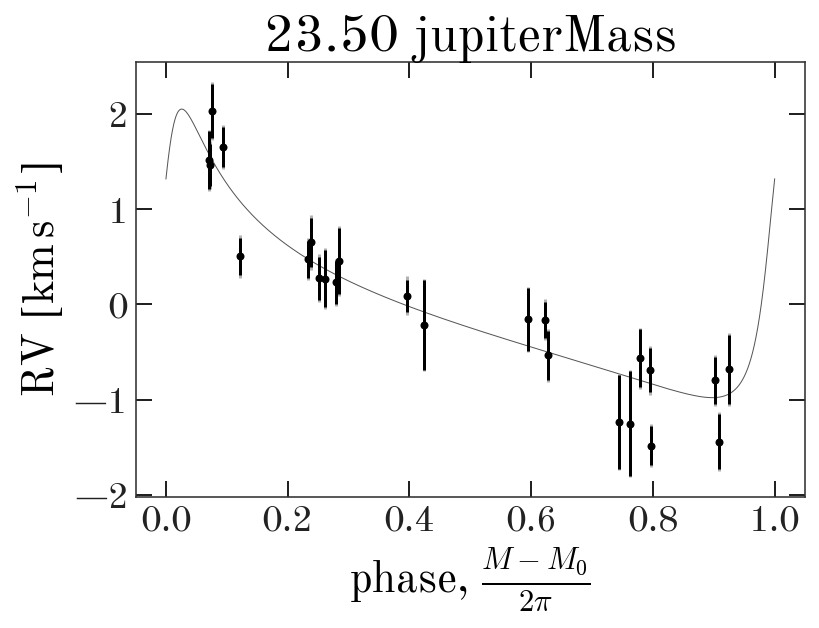

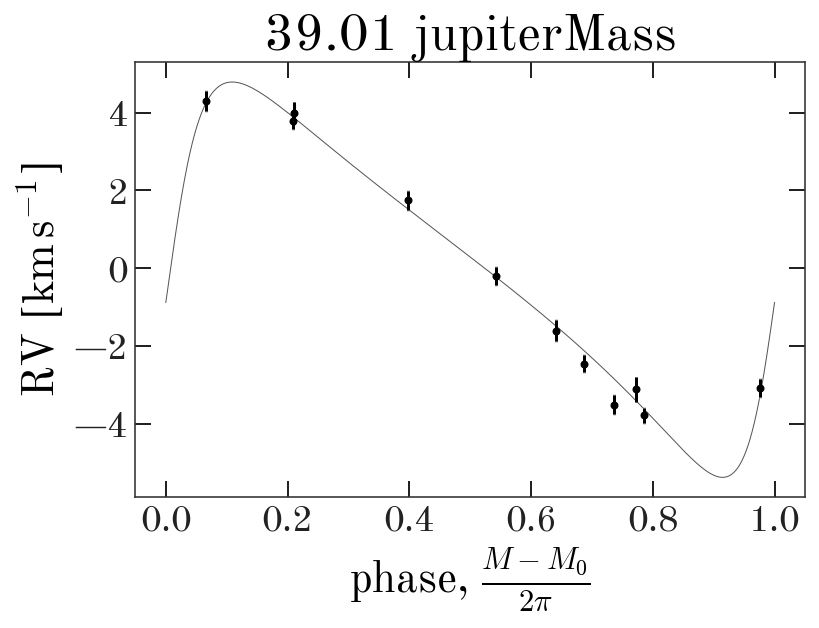

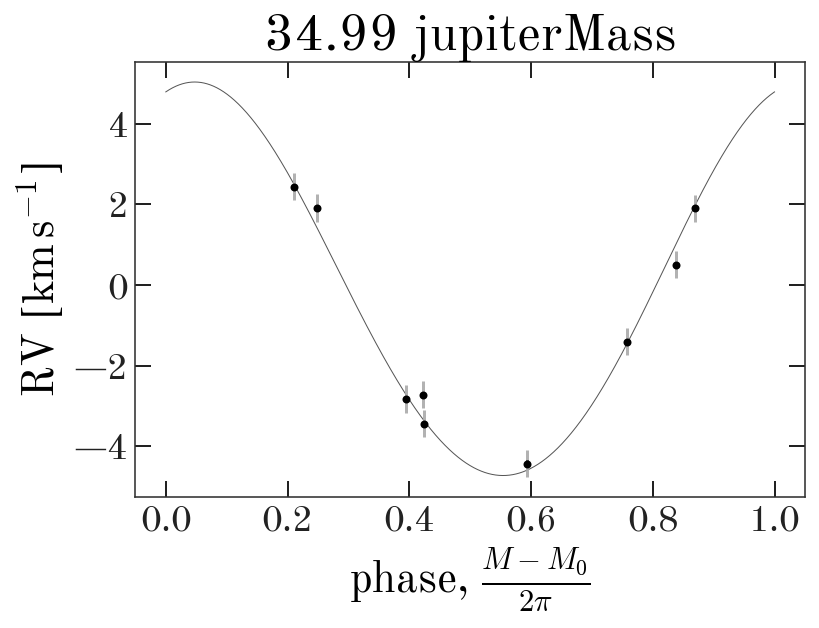

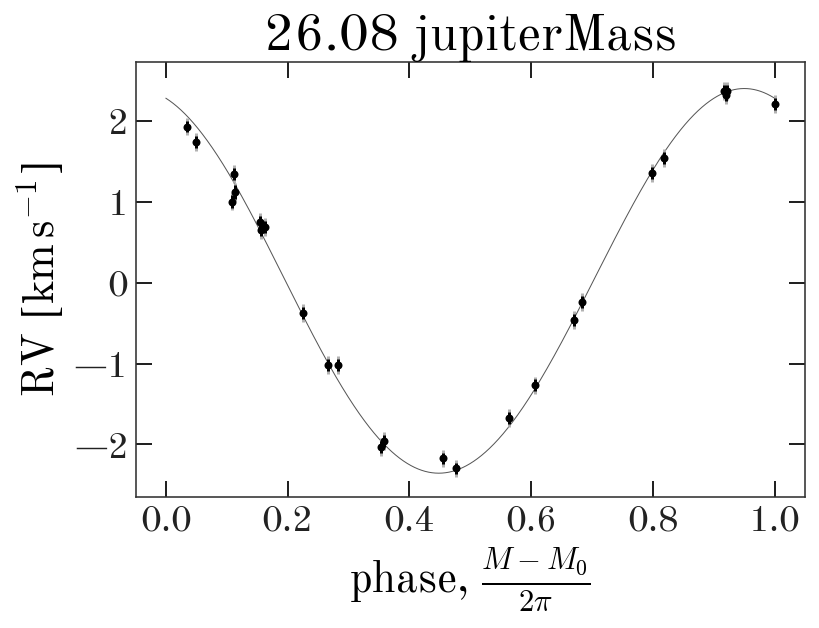

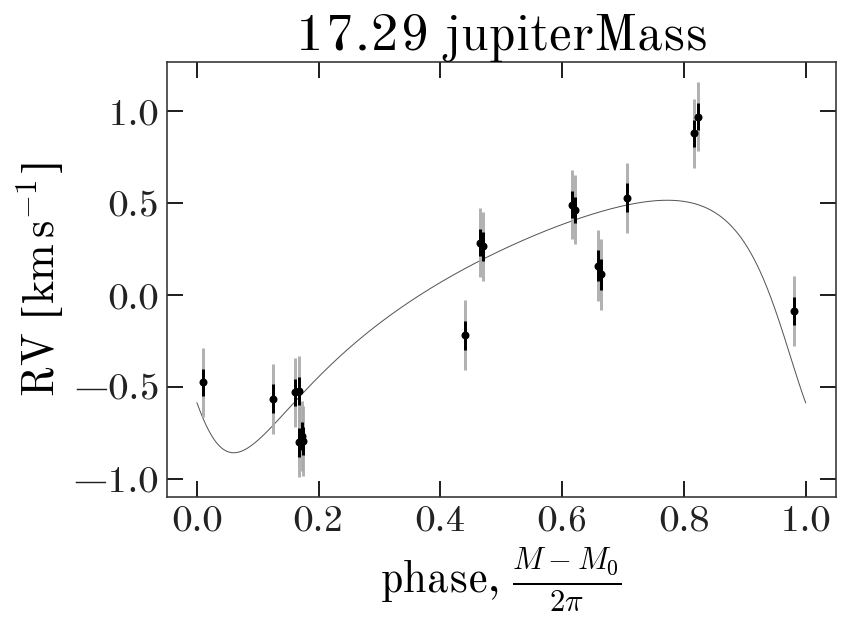

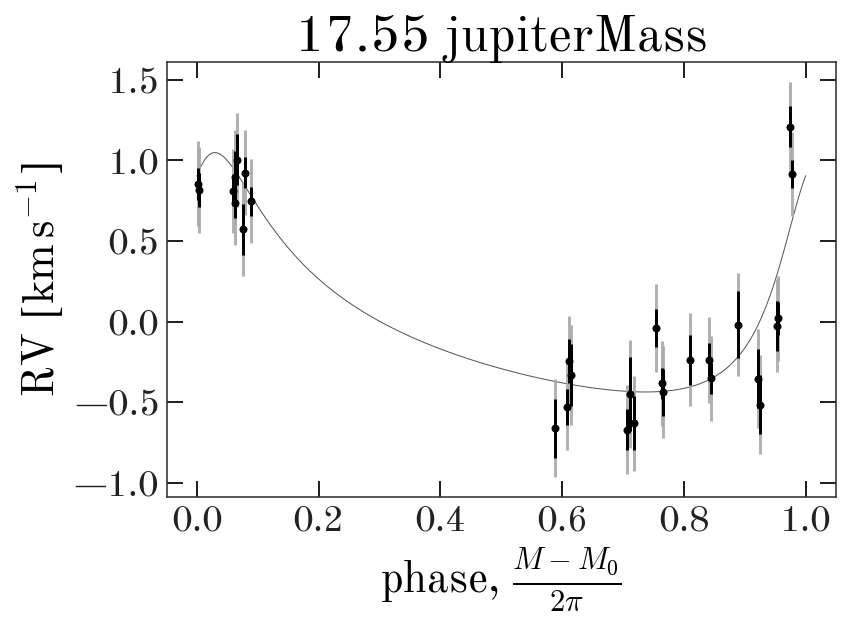

In [17]:
for row in low_mass[:20]:
    apid = row['APOGEE_ID']
    with h5py.File(c.mcmc_results_path, 'r') as f:
        samples = tj.JokerSamples.read(f[apid])
        data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
        
        # fig, ax = plt.subplots()
        # _ = tj.plot_rv_curves(samples[:16], data=data, ax=ax)
                
        fig, ax = plt.subplots()
        sample = samples.median()
        _ = tj.plot_phase_fold(sample, ax=ax, data=data)
        ax.set_title(f"{row['m2_min_50'].to(u.Mjup):.2f}")